Import dependencies.

In [15]:
import os, io, lmdb, sys, torch, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from pathlib import Path
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Define the directory.

In [16]:
PARENT_DIR = Path.cwd().parent
# PARENT_DIR = Path('/content/drive/MyDrive/[FOLDERNAME]')
sys.path.insert(0, str(PARENT_DIR))

print(PARENT_DIR)

C:\Users\User\Downloads\PEAN


In [17]:
from utils.utils import DATASET_DIR

DATASET = "LRLPR"
TRAIN_DIR = os.path.join(DATASET_DIR, DATASET, "train")
TEST_DIR = os.path.join(DATASET_DIR, DATASET, "test")

print(TRAIN_DIR)
print(TEST_DIR)

C:\Users\User\Downloads\PEAN\dataset\LRLPR\train
C:\Users\User\Downloads\PEAN\dataset\LRLPR\test


### Build dataset class

Define the `LRLPRDataset` class.

In [18]:
class LRLPRDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_training=True):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_training = is_training
        self.samples = []

        for track_path in self.root_dir.rglob('track_*'):
            if track_path.is_dir():
                scenario = "Scenario-A" if "Scenario-A" in str(track_path) else "Scenario-B"
                ext = ".png" if scenario == "Scenario-A" else ".jpg"
                anno_path = track_path / "annotations.json"
                label = ""
                if anno_path.exists():
                    with open(anno_path, 'r') as f:
                        label = json.load(f).get('plate_text', "")
                self.samples.append({
                    'path': track_path, 
                    'track_id': track_path.name, 
                    'scenario': scenario, 
                    'extension': ext,
                    'label': label
                })
        
        print(f"Loaded {len(self.samples)} tracks. (A: PNG, B: JPG)")
    
    def _load_sequence(self, track_path, prefix, ext, num_frames=5):
        frames = []
        for i in range(1, num_frames + 1):
            img_path = track_path / f"{prefix}-{i:03d}{ext}"                
            img = Image.open(img_path).convert('RGB')
            frames.append(img)
        return frames

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_info = self.samples[idx]
        track_path = sample_info['path']
        ext = sample_info['extension']
        label = sample_info["label"]
        lr_seq = self._load_sequence(track_path, "lr", ext)
        hr_seq = self._load_sequence(track_path, "hr", ext) if self.is_training else torch.tensor([])

        metadata = {
            "scenario": sample_info['scenario'],
            "track_id": sample_info['track_id'],
        }
            
        return hr_seq, lr_seq, label, metadata

### Playground Section

Test out the `LRLPRDataset` class.

In [20]:
from dataset.dataset import alignCollate_real, alignCollate_real_sequence

dataset = LRLPRDataset(root_dir=TRAIN_DIR)
loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=alignCollate_real_sequence(imgH=32, imgW=128, down_sample_scale=2, mask=False))

for batch in loader:
    hr_images, lr_images, labels, metadata = batch
    track_ids = [m['track_id'] for m in metadata]
    scenarios = [m['scenario'] for m in metadata]
    
    # access first sample in sequence
    img_lr_sample = lr_images[0]
    img_hr_sample = hr_images[0]
    label_sample = labels[0]
    
    print(f"Batch LR shape: {lr_images.shape}")
    print(f"Batch HR shape: {hr_images.shape}")
    print(f"First sample LR shape: {img_lr_sample.shape}")
    print(f"First sample HR shape: {img_hr_sample.shape}")
    print(f"First label: {label_sample}")
    break

Loaded 20000 tracks. (A: PNG, B: JPG)
Batch LR shape: torch.Size([64, 5, 3, 16, 64])
Batch HR shape: torch.Size([64, 5, 3, 32, 128])
First sample LR shape: torch.Size([5, 3, 16, 64])
First sample HR shape: torch.Size([5, 3, 32, 128])
First label: TCA3D75


In [ ]:
print(f"Total (train1+train2): {len(dataset)}")

### Exploratory Data Analysis (EDA)

Load dataset into DataFrame.

In [4]:
data = []
TARGET_PATH = Path(TRAIN_DIR)

for track_dir in TARGET_PATH.rglob("track_*"):
    parts = track_dir.parts
    track_id = track_dir.name
    scenario = parts[-3]
    region = parts[-2]
    ext = ".png" if "Scenario-A" in scenario else ".jpg"
    anno_file = track_dir / "annotations.json"
    
    if anno_file.exists():
        with open(anno_file, 'r') as f:
            anno_data = json.load(f)
            label = anno_data.get('plate_text', "")
            all_corners = anno_data.get('corners', {})

        for lr_file in track_dir.glob(f"lr-*{ext}"):
            file_stem = lr_file.name.replace("lr-", "")
            hr_file = track_dir / f"hr-{file_stem}"
            
            if lr_file.exists() and hr_file.exists():
                with Image.open(lr_file) as lr_img, Image.open(hr_file) as hr_img:
                    lr_w, lr_h = lr_img.size
                    hr_w, hr_h = hr_img.size
                
                data.append({
                    "scenario": scenario,
                    "region": region,
                    "track_id": track_id,
                    "file_id": file_stem.split('.')[0],
                    "extension": ext,
                    "label": label,
                    "lr_width": lr_w,
                    "lr_height": lr_h,
                    "hr_width": hr_w,
                    "hr_height": hr_h,
                    "path": str(track_dir)
                })

A glance at the DataFrame.

In [5]:
df = pd.DataFrame(data).sort_values(by=["scenario", "region", "track_id", "label"])
df = df.reset_index(drop=True)

df.head(10)

,scenario,region,track_id,file_id,extension,label,lr_width,lr_height,hr_width,hr_height,path
0,Scenario-A,Brazilian,track_00001,001,.png,AVL5215,31,17,60,32,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
1,Scenario-A,Brazilian,track_00001,002,.png,AVL5215,33,17,61,31,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
2,Scenario-A,Brazilian,track_00001,003,.png,AVL5215,33,19,58,30,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
3,Scenario-A,Brazilian,track_00001,004,.png,AVL5215,36,20,58,30,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
4,Scenario-A,Brazilian,track_00001,005,.png,AVL5215,36,20,55,27,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
5,Scenario-A,Brazilian,track_00002,001,.png,AZU7127,33,19,81,43,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
6,Scenario-A,Brazilian,track_00002,002,.png,AZU7127,33,19,80,42,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
7,Scenario-A,Brazilian,track_00002,003,.png,AZU7127,34,19,78,42,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
8,Scenario-A,Brazilian,track_00002,004,.png,AZU7127,34,19,78,40,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...
9,Scenario-A,Brazilian,track_00002,005,.png,AZU7127,37,21,76,40,C:\Users\User\Downloads\PEAN\dataset\LRLPR\tra...


Total number of samples.

In [6]:
df.groupby(['scenario', 'region']).size()

scenario    region   
Scenario-A  Brazilian    25000
            Mercosur     25000
Scenario-B  Brazilian    10000
            Mercosur     40000
dtype: int64

View some sample images.

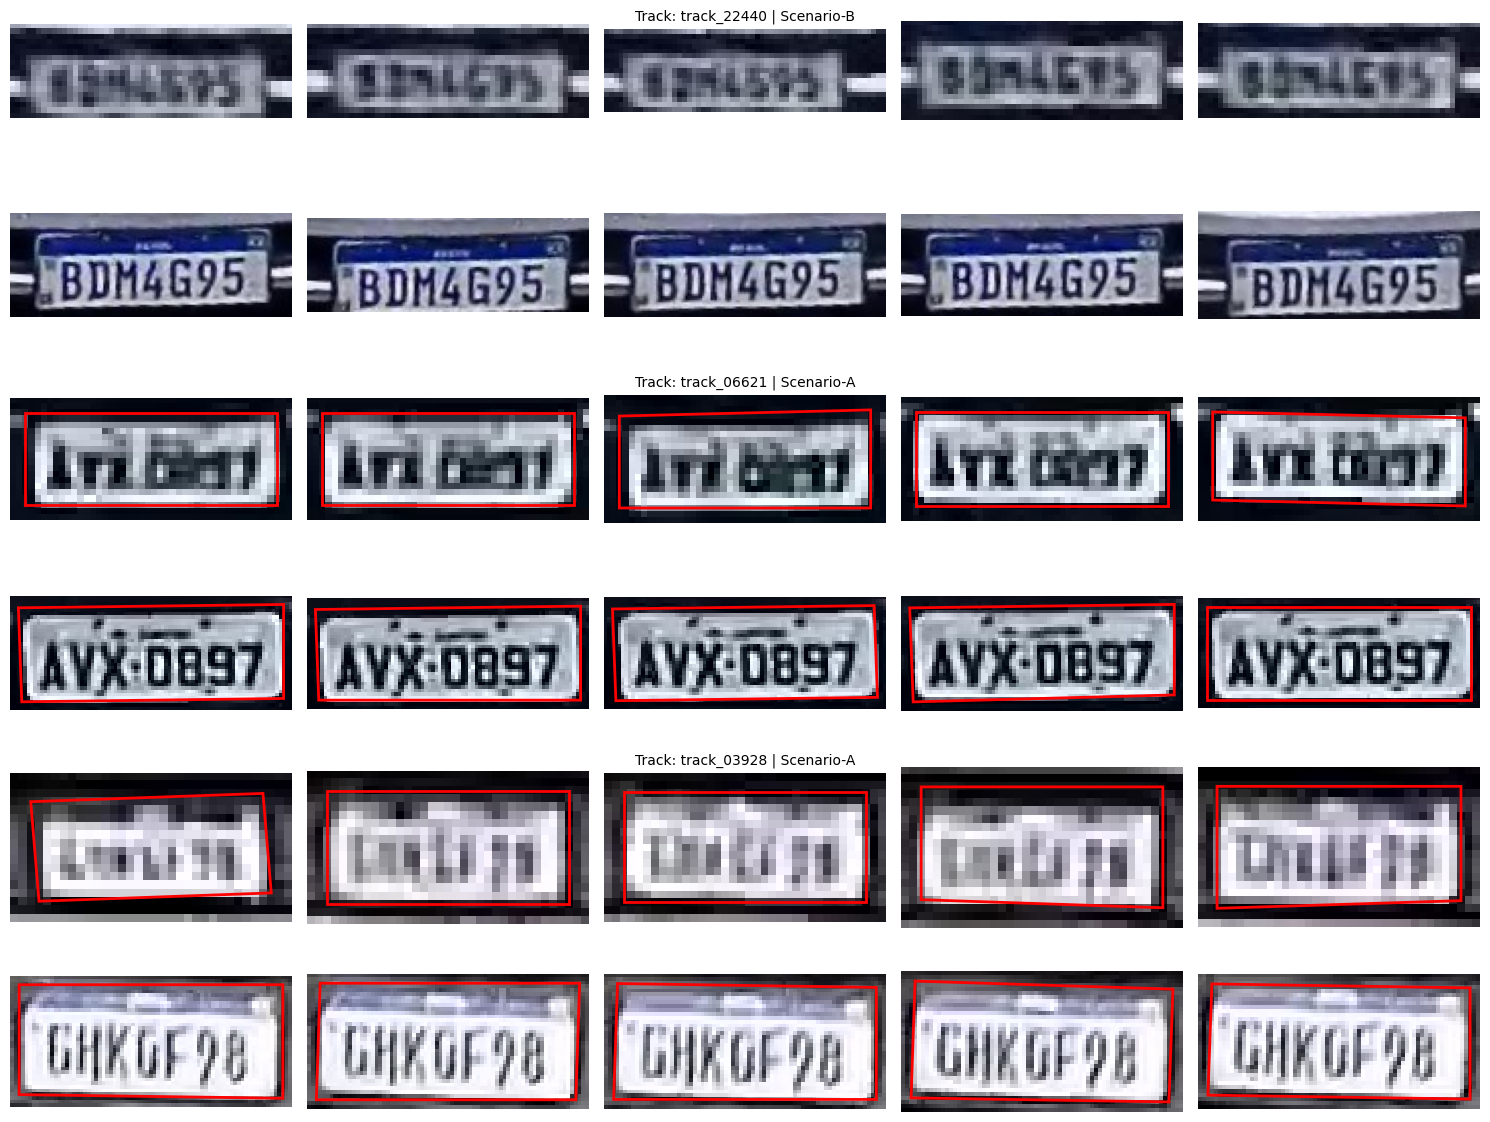

In [7]:
import matplotlib.patches as patches

NUM_TRACKS = 3
NUM_FRAMES = 5

sampled_tracks = df.sample(NUM_TRACKS)
fig, axes = plt.subplots(NUM_TRACKS * 2, NUM_FRAMES, figsize=(15, 4 * NUM_TRACKS))

for idx, (i, row_data) in enumerate(sampled_tracks.iterrows()):
    track_path = Path(row_data['path'])
    scenario = row_data['scenario']
    region = row_data['region']
    ext = row_data['extension']
    is_scenario_a = "Scenario-A" in scenario
    
    with open(track_path / "annotations.json", 'r') as f:
        anno_full = json.load(f)
        label = anno_full.get('plate_text', 'Unknown')
        all_corners = anno_full.get('corners', {}) if is_scenario_a else {}

    lr_row_idx = idx * 2
    hr_row_idx = idx * 2 + 1

    for frame_idx in range(1, NUM_FRAMES + 1):
        frame_name_lr = f"lr-{frame_idx:03d}{ext}"
        frame_name_hr = f"hr-{frame_idx:03d}{ext}"

        # Helper to plot image and corners
        for r_idx, f_name, img_type in [(lr_row_idx, frame_name_lr, "LR"), 
                                        (hr_row_idx, frame_name_hr, "HR")]:
            
            ax = axes[r_idx, frame_idx-1]
            img = Image.open(track_path / f_name)
            ax.imshow(img)
            ax.axis('off')

            # Draw Corners if Scenario A
            if is_scenario_a and f_name in all_corners:
                c = all_corners[f_name]
                # Order for polygon: TL -> TR -> BR -> BL
                pts = [c['top-left'], c['top-right'], c['bottom-right'], c['bottom-left']]
                poly = patches.Polygon(pts, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(poly)

            # Labels and Titles
            if frame_idx == 1:
                ax.set_ylabel(f"{img_type}\n{label}", rotation=0, labelpad=40, fontsize=10, fontweight='bold')
            if frame_idx == 3 and img_type == "LR": # Title in the middle column
                ax.set_title(f"Track: {row_data['track_id']} | {scenario}", fontsize=10)

plt.tight_layout()
plt.show()

Check the Aspect Ratio.

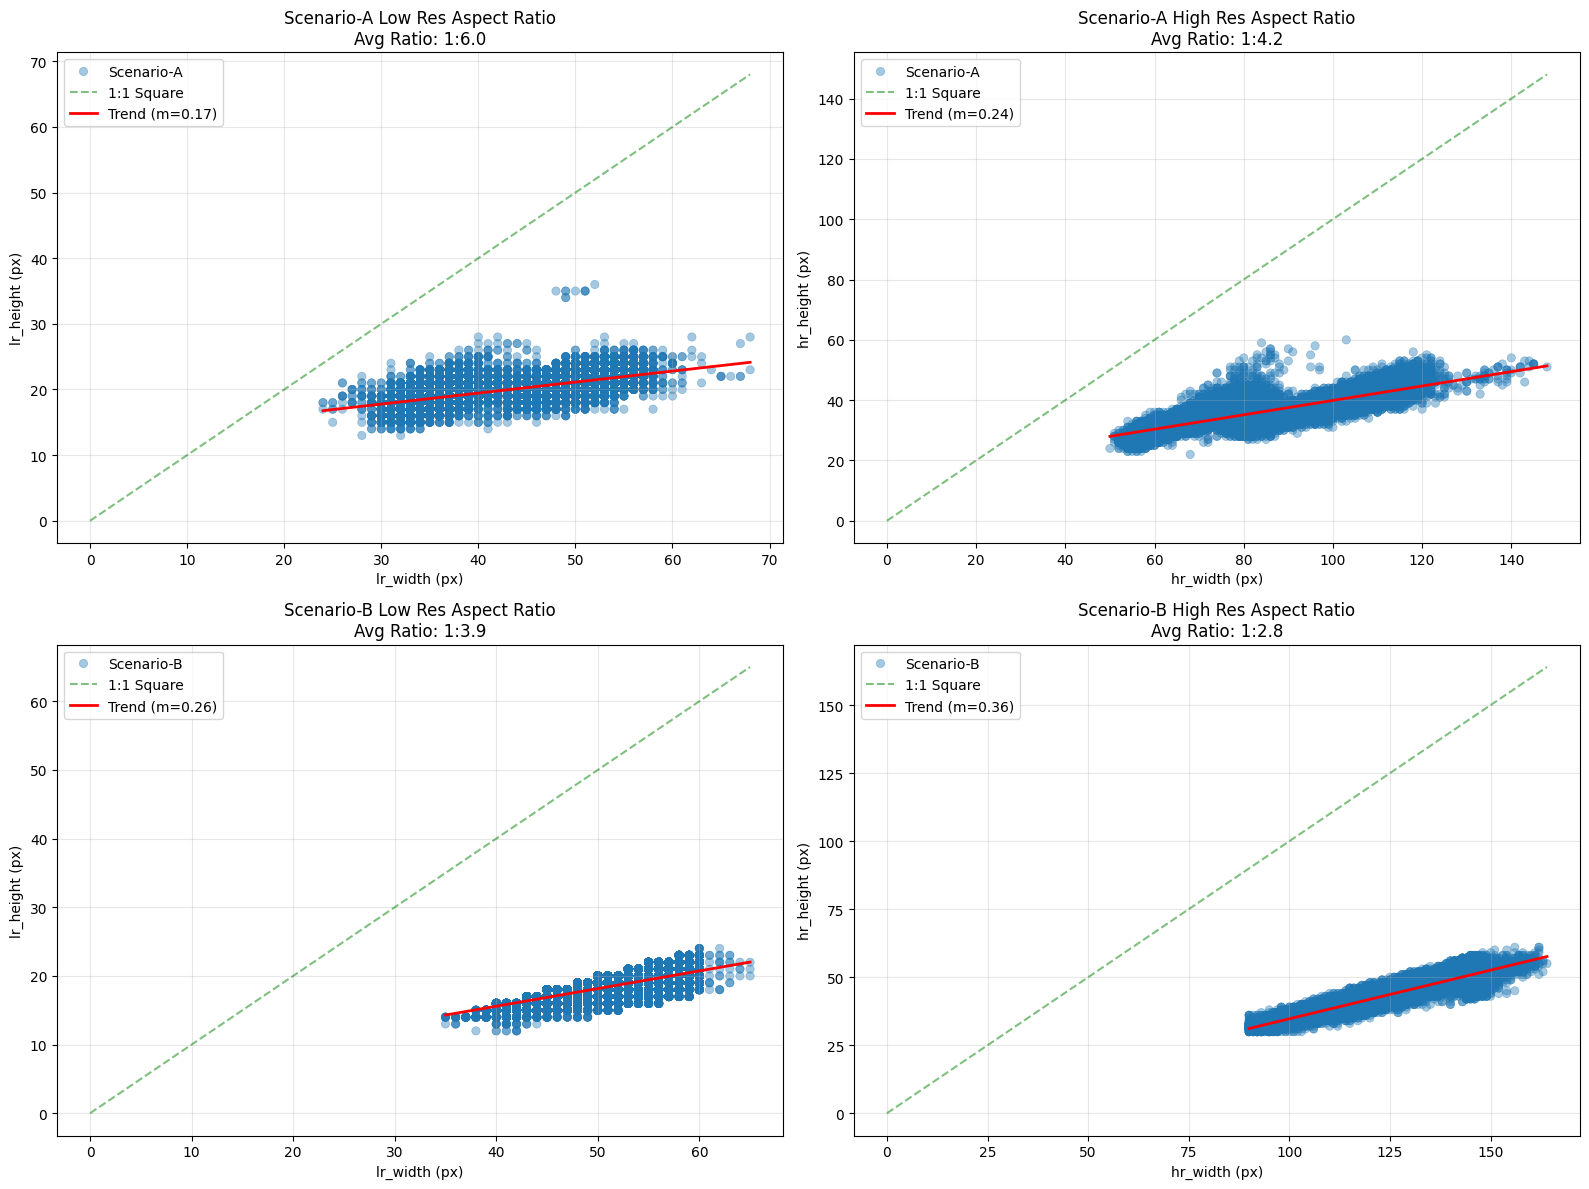

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False, sharey=False)
scenarios = ['Scenario-A', 'Scenario-B']
resolutions = [('lr_width', 'lr_height', 'Low Res'), 
               ('hr_width', 'hr_height', 'High Res')]

for row, scenario in enumerate(scenarios):
    # Filter data for current scenario
    scenario_df = df[df['scenario'] == scenario]
    
    for col, (w_col, h_col, res_type) in enumerate(resolutions):
        ax = axes[row, col]
        
        # 1. Calculate Trend Line
        m, b = np.polyfit(scenario_df[w_col], scenario_df[h_col], 1)
        x_line = np.array([scenario_df[w_col].min(), scenario_df[w_col].max()])
        y_line = m * x_line + b
        
        # 2. Scatter Plot
        sns.scatterplot(data=scenario_df, x=w_col, y=h_col, 
                        hue="scenario", alpha=0.4, edgecolor=None, ax=ax)
        
        # 3. Add 1:1 Reference Line
        max_val = max(scenario_df[w_col].max(), scenario_df[h_col].max())
        ax.plot([0, max_val], [0, max_val], color='green', 
               linestyle='--', alpha=0.5, label='1:1 Square')
        
        # 4. Add Trend Line
        ax.plot(x_line, y_line, color='red', linewidth=2, 
               label=f'Trend (m={m:.2f})')
        
        # Formatting
        ax.set_title(f"{scenario} {res_type} Aspect Ratio\nAvg Ratio: 1:{1/m:.1f}")
        ax.set_xlabel(f"{w_col} (px)")
        ax.set_ylabel(f"{h_col} (px)")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This tells us:
<br>
1. Resolution Disparity and Scaling
    - Pixel Density: The dataset contains High-Resolution (HR) ground truth and significantly degraded Low-Resolution (LR) images to simulate real-world surveillance limitations.
    - Fixed-Height Scaling: The Low-Res images show a slope of $m=0.08$ (Ratio $1:12.2$), while High-Res shows $m=0.22$ (Ratio $1:4.4$). This indicates the LR plates were likely resized to a fixed vertical height (e.g., 16px) regardless of their original width, causing significant vertical compression.
2. Geometric Distortion (The "Squash" Effect)
    - Non-Isotropic Scaling: The scaling factor is not uniform; height is compressed much more aggressively than width.
    - Model Challenge: A Super-Resolution model must learn to "re-stretch" the license plates vertically to restore the original aspect ratio of the characters.
3. Scenario-Based Characteristics
    - Scenario-A (Day/Standard): In HR, these cluster at smaller widths ($50$–$125$px), suggesting a more consistent capture distance or standard plate size.
    - Scenario-B (Varied/Complex): These exhibit a much wider distribution in HR width ($100$–$160$px), likely representing diverse capture angles, nighttime conditions, or closer proximity to the sensor.

How many samples are `stretched` or `distorted`?

In [9]:
# Calculate independent scaling for width and height
df['w_scale'] = df['hr_width'] / df['lr_width']
df['h_scale'] = df['hr_height'] / df['lr_height']
imbalanced = df[df['w_scale'] != df['h_scale']]
print(f"Number of tracks with distorted scaling: {len(imbalanced)}")

# Look at the first few distorted tracks
imbalanced[['track_id', 'file_id', 'w_scale', 'h_scale']].head()

Number of tracks with distorted scaling: 99401


,track_id,file_id,w_scale,h_scale
0,track_00001,001,1.935484,1.882353
1,track_00001,002,1.848485,1.823529
2,track_00001,003,1.757576,1.578947
3,track_00001,004,1.611111,1.500000
4,track_00001,005,1.527778,1.350000


Check the frequency of the characters.

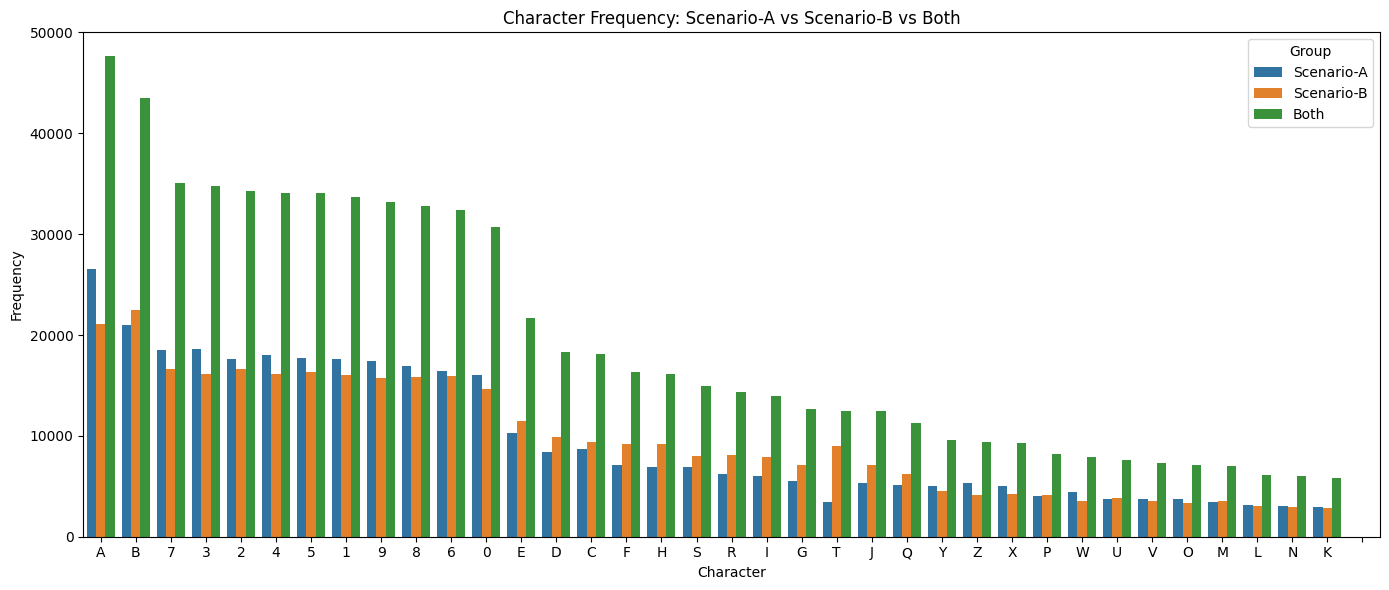

In [10]:
def get_char_freqs(text_series, label):
    counts = Counter("".join(text_series.astype(str)))
    temp_df = pd.DataFrame(counts.items(), columns=["char", "count"])
    temp_df["Scenario"] = label
    return temp_df

# 2. Split data and calculate frequencies
df_a = df[df['scenario'] == 'Scenario-A']
df_b = df[df['scenario'] == 'Scenario-B']

freq_a = get_char_freqs(df_a['label'], "Scenario-A")
freq_b = get_char_freqs(df_b['label'], "Scenario-B")
freq_both = get_char_freqs(df['label'], "Both")

# 3. Combine into one DataFrame for plotting
all_freqs = pd.concat([freq_a, freq_b, freq_both], ignore_index=True)

# 4. Determine sorting order (sorted by highest total frequency)
char_order = freq_both.sort_values("count", ascending=False)["char"].tolist()

# 5. Plotting
plt.figure(figsize=(14, 6))
sns.barplot(data=all_freqs, x="char", y="count", hue="Scenario", order=char_order)

plt.title("Character Frequency: Scenario-A vs Scenario-B vs Both")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.legend(title="Group")
plt.tight_layout()